In [28]:
import time
import requests
import pandas as pd

USERNAME = "your_username"
PASSWORD = "your_password"
TGT = None
TGT_OBTAIN_TIME = None

#request
def get_tgt():
    global TGT, TGT_OBTAIN_TIME
    url = "https://giris.epias.com.tr/cas/v1/tickets"
    resp = requests.post(
        url,
        data={"username": USERNAME, "password": PASSWORD},
        allow_redirects=False
    )
    if resp.status_code == 201:
        TGT = resp.headers["location"].split("/")[-1]
        TGT_OBTAIN_TIME = time.time()
        print("✅ TGT alındı")
    else:
        raise RuntimeError(f"TGT alınamadı: {resp.status_code}")

def ensure_tgt():
    if TGT is None or (time.time() - TGT_OBTAIN_TIME > 6840):
        get_tgt()

def fetch_interim_mcp(start_date, end_date):
    ensure_tgt()
    url = "https://seffaflik.epias.com.tr/electricity-service/v1/markets/dam/data/interim-mcp"
    headers = {
        "TGT": TGT,
        "Content-Type": "application/json"
    }
    body = {
        "startDate": f"{start_date}T00:00:00+03:00",
        "endDate": f"{end_date}T23:00:00+03:00"
    }
    resp = requests.post(url, headers=headers, json=body)
    try:
        resp_json = resp.json()
        if "items" in resp_json:
            df = pd.DataFrame(resp_json["items"])
            df["timestamp"] = pd.to_datetime(df["date"])
            return df[["timestamp", "marketTradePrice"]]
        else:
            return pd.DataFrame()
    except Exception as e:
        print("JSON parse hatası:", e)
        return pd.DataFrame()

get_tgt()

# 1️⃣ train ( 11-14 nov)
dfs = []
for day in ["2024-11-11", "2024-11-12", "2024-11-13", "2024-11-14"]:
    df_day = fetch_interim_mcp(day, day)
    if not df_day.empty:
        dfs.append(df_day)
    else:
        print(f"❌ Veri yok: {day}")
    time.sleep(1)
df_train = pd.concat(dfs, ignore_index=True)
df_train = df_train.rename(columns={"marketTradePrice": "mcp"})
df_train.set_index("timestamp", inplace=True)
df_train.to_csv("egitim_mcp.csv")
print("✅ Eğitim (11-14 Kasım) CSV kaydedildi:", df_train.shape)

# 2️⃣ test(15 nov)
df_test = fetch_interim_mcp("2024-11-15", "2024-11-15")
df_test = df_test.rename(columns={"marketTradePrice": "real_mcp"})
df_test.set_index("timestamp", inplace=True)
df_test.to_csv("test_mcp.csv")
print("✅ Test (15 Kasım) CSV kaydedildi:", df_test.shape)


✅ TGT alındı
✅ Eğitim (11-14 Kasım) CSV kaydedildi: (96, 1)
✅ Test (15 Kasım) CSV kaydedildi: (24, 1)


X shape: (49, 24, 1)
y shape: (49, 24)


C:\ProgramData\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


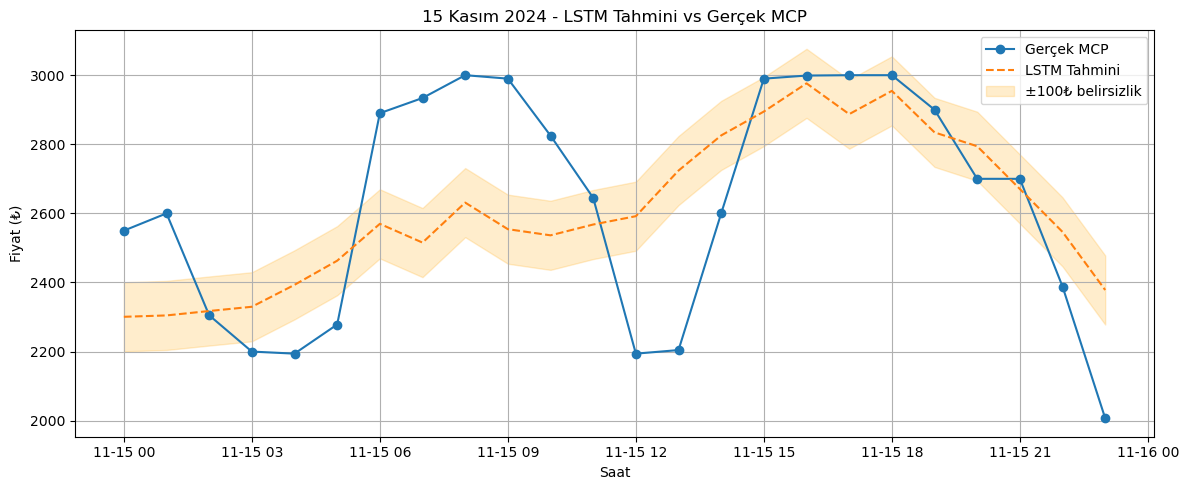

 MAE: 213.22 ₺
RMSE: 259.27 ₺

 İlk 5 saatlik karşılaştırma:
                           real_mcp  predicted_mcp        hata
timestamp                                                     
2024-11-15 00:00:00+03:00   2549.99    2300.665283  249.324717
2024-11-15 01:00:00+03:00   2599.99    2304.616211  295.373789
2024-11-15 02:00:00+03:00   2304.99    2317.392822   12.402822
2024-11-15 03:00:00+03:00   2199.99    2329.675537  129.685537
2024-11-15 04:00:00+03:00   2194.01    2393.165771  199.155771


In [30]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# read train&test
df_train = pd.read_csv("egitim_mcp.csv", parse_dates=["timestamp"], index_col="timestamp")
df_test = pd.read_csv("test_mcp.csv", parse_dates=["timestamp"], index_col="timestamp")

# Normalisation
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train[["mcp"]])

# Sequence-to-sequence 
X, y = [], []
seq_len = 24
for i in range(len(scaled_train) - seq_len - 23):
    X.append(scaled_train[i:i+seq_len].reshape(seq_len, 1))
    y.append(scaled_train[i+seq_len:i+seq_len+24].flatten())
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(seq_len, 1)))
model.add(LSTM(32))
model.add(Dense(24))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

# forecast 15 nov.
last_seq = scaled_train[-seq_len:].reshape(1, seq_len, 1)
pred_scaled = model.predict(last_seq)[0]
predicted_mcp = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

# Result
df_result = df_test.copy()
df_result["predicted_mcp"] = predicted_mcp
df_result["hata"] = (df_result["real_mcp"] - df_result["predicted_mcp"]).abs()
mae = df_result["hata"].mean()
rmse = np.sqrt((df_result["hata"] ** 2).mean())

plt.figure(figsize=(12, 5))
plt.plot(df_result.index, df_result["real_mcp"], label="Gerçek MCP", marker="o")
plt.plot(df_result.index, df_result["predicted_mcp"], label="LSTM Tahmini", linestyle="--")
plt.fill_between(df_result.index,
                 df_result["predicted_mcp"] - 100,
                 df_result["predicted_mcp"] + 100,
                 color='orange', alpha=0.2, label="±100₺ belirsizlik")
plt.title("15 Kasım 2024 - LSTM Tahmini vs Gerçek MCP")
plt.xlabel("Saat")
plt.ylabel("Fiyat (₺)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(" MAE:", round(mae, 2), "₺")
print("RMSE:", round(rmse, 2), "₺")
print("\n İlk 5 saatlik karşılaştırma:")
print(df_result.head())
